# Emir Can İPSALALI - eipsalal@gmail.com

# Veri Yoğun Uygulamalar Projesi

---

---

# <span style="color: red;">Bölüm 1.</span> Gerekli Kütüphanelerin Yüklenmesi


In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import pandas as pd
import numpy as np
import itertools
import time

import yfinance as yf
import requests
from bs4 import BeautifulSoup
from io import StringIO, BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import matplotlib.pyplot as plt
import seaborn as sns
import os

from ucimlrepo import fetch_ucirepo
from collections import Counter
from ydata_profiling import ProfileReport

---

# <span style="color: red;">Bölüm 2.</span> **Veri Toplama - Web Scraping - Veri Önişleme**

## **<span style="color: red;">2.1.</span> Sektör İsimlerini Çekme (`fetch_sectors_names`)**

Bu bölümde, Python kullanarak **StockAnalysis** web sitesinden sektör, endüstri ve hisse senedi verilerini toplamak için **web scraping** yöntemini kullanacağız.

Kodda **`requests`**, **`BeautifulSoup`**, ve **`pandas`** kütüphaneleri kullanılarak HTML verileri çekilip tablolar halinde işlenmektedir.


In [ ]:
def fetch_sectors_names():
    url = "https://stockanalysis.com/stocks/industry/sectors/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")

    return df

def fetch_industry_names():
    url = "https://stockanalysis.com/stocks/industry/all/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")

    return df

def fetch_data(sectors):
    url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(StringIO(str(soup.find_all("table"))))[0]
        df.drop(columns='No.', inplace=True)
    else:
        print(f"Error: Failed to fetch data from page {url}")

    return df

In [ ]:
sectors=fetch_sectors_names()
indusrty=fetch_industry_names()

In [ ]:
sectors

##  **<span style="color: red;">2.2.</span> Verilerin Kaydedilmesi (`.csv` Formatında)**

Bu bölümde, **StockAnalysis** web sitesinden çekilen hisse senedi verileri `.csv` dosyalarına kaydedilecek ve ardından analiz için yüklenecektir.

* Öncelikle, veri saklamak için **`../data/stock_sectors/`** dizini oluşturulmuştur:
* Ardından, belirli sektörlere ait hisse senedi verileri çekilip .csv dosyalarına kaydedilmiştir:

In [ ]:
fetch_data(sectors='energy').to_csv('../data/stock_sectors/energy.csv')
fetch_data(sectors='financials').to_csv('../data/stock_sectors/financials.csv')
fetch_data(sectors='healthcare').to_csv('../data/stock_sectors/healthcare.csv')
fetch_data(sectors='technology').to_csv('../data/stock_sectors/technology.csv')
fetch_data(sectors='utilities').to_csv('../data/stock_sectors/utilities.csv')
fetch_data(sectors='real-estate').to_csv('../data/stock_sectors/real-estate.csv')
fetch_data(sectors='materials').to_csv('../data/stock_sectors/materials.csv')
fetch_data(sectors='technology').to_csv('../data/stock_sectors/technology.csv')
fetch_data(sectors='industrials').to_csv('../data/stock_sectors/industrials.csv')
fetch_data(sectors='consumer-staples').to_csv('../data/stock_sectors/consumer-staples.csv')
fetch_data(sectors='consumer-discretionary').to_csv('../data/stock_sectors/consumer-discretionary.csv')
fetch_data(sectors='communication-services').to_csv('../data/stock_sectors/communication-services.csv')

In [ ]:
# Veriyi yükle
finance = pd.read_csv('../data/stock_sectors/financials.csv')
healthcare = pd.read_csv('../data/stock_sectors/healthcare.csv')
technology = pd.read_csv('../data/stock_sectors/technology.csv')

finance.Symbol
healthcare.Symbol
technology.Symbol

---
##  **<span style="color: red;">2.3.</span> Hisse Senedi Sembollerinin Çekilmesi ve Temizlenmesi**

Veri çerçevelerinde yer alan Symbol sütunu seçilerek, boş değerler atılmış ve benzersiz hisse senedi sembolleri alınmıştır:

In [ ]:
# "Symbol" sütunlarını al ve temizle
finance_symbols = finance['Symbol'].dropna().unique().tolist()
healthcare_symbols = healthcare['Symbol'].dropna().unique().tolist()
technology_symbols = technology['Symbol'].dropna().unique().tolist()


# Kontrol amaçlı kaç adet hisse sembolü alındığını yazdıralım
print(f"Finans: {len(finance_symbols)} hisse")
print(f"Sağlık: {len(healthcare_symbols)} hisse")
print(f"Teknoloji: {len(technology_symbols)} hisse")

---
## **<span style="color: red;">2.4.</span> Hisse Seçimi ve Kapanış Fiyatlarının Çekilmesi**

 **Mevcut Hisse Sayıları:** Yukarıdaki kodda görüldüğü üzere
- 📊 **Finance** sektöründe **883 adet** hisse bulunuyor.  
- 🏥 **Healthcare** sektöründe **1169 adet** hisse bulunuyor.  
- 💻 **Technology** sektöründe **769 adet** hisse bulunuyor.  



**Planlanan İşlemler:**
✅ **Her sektörden 500 adet hisse seçilecek** (toplam **1500 hisse** olacak).  
✅ **Yahoo Finance**'den **2005-01-01** tarihinden itibaren aylık olarak **"Close" (Kapanış) fiyatları** çekilecek.  
📂 **Çıktı olarak**, her hissenin **kapanış fiyatlarının bulunduğu bir veri seti** oluşturulacak.

**<span style="color: red;">NOT</span>** : Veri toplama sürecindeki en önemli hususlardan biri, Yahoo Finance API'sinin sınırlamalarına dikkat etmektir.
* Çok fazla istekte bulunmak API tarafından engellenmenize neden olabilir.
* time.sleep(5) gecikmesi eklenerek bu risk azaltılmıştır.
* Veri çekme sırasında boş veya hatalı sütunların temizlenmesi gereklidir, aksi takdirde analizler yanlış sonuç verebilir.



---

### **<span style="color: red;">2.4.1.</span> Finance İçin Veri Çekimi**

In [ ]:
fetch_size = 50

ticker_parts = [finance_symbols[i:i+fetch_size] for i in range(0, len(finance_symbols), fetch_size)]

data_list_finance = []

for part in ticker_parts:
    try:
        data = yf.download(part, start='2005-01-01',interval="1mo", threads= False)
        data_list_finance.append(data)
        time.sleep(5)  # 5 saniye bekleme, API limitini aşmamak için
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

In [ ]:
# Sonuçları birleştir
finance_data = pd.concat(data_list_finance, axis=1)

# "Close" fiyatlarını al
finance_data_close = finance_data['Close']

In [ ]:
finance_data_close

---

### **<span style="color: red;">2.4.2.</span> Healthcare İçin Veri Çekimi**

In [ ]:
fetch_size = 50

ticker_parts = [healthcare_symbols[i:i+fetch_size] for i in range(0, len(healthcare_symbols), fetch_size)]

data_list_healthcare = []

for part in ticker_parts:
    try:
        data = yf.download(part, start='2005-01-01',interval="1mo", threads= False)
        data_list_healthcare.append(data)
        time.sleep(5)  # 5 saniye bekleme, API limitini aşmamak için
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

In [ ]:
# Sonuçları birleştir
healthcare_data = pd.concat(data_list_healthcare, axis=1)

# "Close" fiyatlarını al
healthcare_data_close = healthcare_data['Close']

In [ ]:
healthcare_data_close

---

### **<span style="color: red;">2.4.3.</span> Technology İçin Veri Çekimi**

In [ ]:
fetch_size = 50

ticker_parts = [technology_symbols[i:i+fetch_size] for i in range(0, len(technology_symbols), fetch_size)]

data_list_technology = []

for part in ticker_parts:
    try:
        data = yf.download(part, start='2005-01-01',interval="1mo", threads= False)
        data_list_technology.append(data)
        time.sleep(5)  # 5 saniye bekleme, API limitini aşmamak için
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")

In [ ]:
# Sonuçları birleştir
technology_data = pd.concat(data_list_technology, axis=1)

# "Close" fiyatlarını al
technology_data_close = technology_data['Close']

In [ ]:
technology_data_close

---

In [ ]:
# Bir daha, veri çekmeyle uğraşmamak için bu topladığım veriyi depoladım.

finance_data_close.to_parquet("../data/ayriayrisektorler/finance_data_close.gzip", compression="gzip")
healthcare_data_close.to_parquet("../data/ayriayrisektorler/healthcare_data_close.gzip", compression="gzip")
technology_data_close.to_parquet("../data/ayriayrisektorler/technology_data_close.gzip", compression="gzip")

In [ ]:
# Finance sektörü verilerini okuma
finance_data_zip = pd.read_parquet("../data/ayriayrisektorler/finance_data_close.gzip")

# Healthcare sektörü verilerini okuma
healthcare_data_zip = pd.read_parquet("../data/ayriayrisektorler/healthcare_data_close.gzip")

# Technology sektörü verilerini okuma
technology_data_zip = pd.read_parquet("../data/ayriayrisektorler/technology_data_close.gzip")

In [ ]:
finance_data_zip

---

## **<span style="color: red;">2.5.</span> Sektörel Çekilen Verilerin Birleştirilmesi için Adımlar (Veri Önişleme)**

Görüldüğü gibi **883 columns (financial)** var fakat yfinance üzerinden veri çekerken hata olabiliyor ve çekilemeyen hisse senedi de veriye ekleniyor. Tamamen boş olan sütunları (Hisse Senetleri) veriden çıkarmamız gerekiyor.

In [ ]:
# Tamamen boş olan sütunları her bir DataFrame'den silme
finance_data_clean = finance_data_zip.dropna(axis=1, how='all')
healthcare_data_clean = healthcare_data_zip.dropna(axis=1, how='all')
technology_data_clean = technology_data_zip.dropna(axis=1, how='all')

# Temizlenmiş verileri kontrol etmek için ilk beş satırı yazdırma (FİNANCE için)
print("Finance Data Cleaned:")
print(finance_data_clean)

Boş olan hisse senetlerini (Çekilemeyen Veri) çıkardığımızda geriye **867 columns** kalıyor.

In [ ]:
# Her bir temizlenmiş DataFrame'deki sütun sayısını yazdırma
print("Temizlenmiş finans veri setindeki sütun sayısı:", finance_data_clean.shape[1])
print("Temizlenmiş sağlık veri setindeki sütun sayısı:", healthcare_data_clean.shape[1])
print("Temizlenmiş teknoloji veri setindeki sütun sayısı:", technology_data_clean.shape[1])

---
### **<span style="color: red;">2.5.1.</span> Eksik Verilerle İlgilenme**

Şimdi öncelikle bu verilerde hisselerin (sütunlar) verilerinin eksik veri yüzdeliğine göre inceleyelim

In [ ]:
finance_data_clean.isna().mean()

Bu oranlar, her bir sütundaki eksik değerlerin toplam satır sayısına oranını gösterir. Çıktıda sütun isimleri ve karşılık gelen eksik veri yüzdeleri yer alıyor.

Örneğin, **APO** sütununda yaklaşık %30.58, **SNTG** sütununda ise %81.82 oranında eksik veri bulunuyor. Bu, bazı hisselerin veri setinde önemli miktarda eksik veriye sahip olduğunu gösteriyor.

* Boş verileri doldurmadan önce, belirli bir eşik değerin altında (örneğin %60-70'in altında) doluluk oranına sahip sütunları silme

In [ ]:
# Eksik veri eşik değeri (örneğin %0 eksik veri kabul edilebilir, bu %60 doluluk anlamına gelir)
threshold = 0.7

# Eksik veri oranı eşik değerinden az olan sütunları koruyarak yeni DataFrame'ler oluşturma
finance_data_dropped = finance_data_clean.loc[:, finance_data_clean.isna().mean() < threshold]
healthcare_data_dropped = healthcare_data_clean.loc[:, healthcare_data_clean.isna().mean() < threshold]
technology_data_dropped = technology_data_clean.loc[:, technology_data_clean.isna().mean() < threshold]

In [ ]:
# Eksik veri oranları ile temizlenmiş veri setlerinin kontrolü
print("Finance Data Dropped Column Count:", finance_data_dropped.shape[1])
print("Healthcare Data Dropped Column Count:", healthcare_data_dropped.shape[1])
print("Technology Data Dropped Column Count:", technology_data_dropped.shape[1])

<span style="color: red;">Eksik verileri yönetmek ve veri setlerini standart hale getirmek için, her veri setinde en fazla dolu (eksik verisi en az olan) 465 sütunu seçiyoruz. Bu seçim, veri bütünlüğünü koruyarak makine öğrenmesi modellerinin daha tutarlı ve dengeli çalışmasını sağlar.</span>

In [ ]:
# Doluluk oranlarını hesaplayarak en fazla dolu olan 465 sütunu seçme

def select_top_filled_columns(df, top_n=465):
    completeness_ratio = df.notnull().mean()
    top_columns = completeness_ratio.nlargest(top_n).index
    return df[top_columns]

# Finance, Healthcare ve Technology için işlemi gerçekleştir
finance_data_selected = select_top_filled_columns(finance_data_dropped, 465)
healthcare_data_selected = select_top_filled_columns(healthcare_data_dropped, 465)
technology_data_selected = select_top_filled_columns(technology_data_dropped, 465)

# Sonuçları kontrol et
print("Finance Data Selected Column Count:", finance_data_selected.shape[1])
print("Healthcare Data Selected Column Count:", healthcare_data_selected.shape[1])
print("Technology Data Selected Column Count:", technology_data_selected.shape[1])


---
### **<span style="color: red;">2.5.2.</span> Eksik Verileri Doldurma** - <span style="color: red;">İleri (Forward Fill) veya Geri (Backward Fill) Yöntemi</span>

Eksik verileri doldurmak, veri analizi süreçlerinde önemli bir adımdır. Özellikle zaman serisi veya finansal veriler gibi sürekli veri akışlarında, boş (NaN) değerler analiz sonuçlarını olumsuz etkileyebilir. Bu nedenle, eksik değerleri doldurmak için **Forward Fill (İleri Doldurma)** ve **Backward Fill (Geri Doldurma)** yöntemleri kullanılır.

 **İleri (Forward Fill) ve Geri (Backward Fill) Yöntemleri**
- **Forward Fill (ffill)**: Eksik değerleri, **önceki satırın değeriyle doldurur**. Eğer bir hücre boşsa, üstündeki en yakın dolu hücrenin değerini alır.
- **Backward Fill (bfill)**: Eksik değerleri, **sonraki satırın değeriyle doldurur**. Eğer bir hücre boşsa, altındaki en yakın dolu hücrenin değerini alır.

 **Yöntemin Uygulanışı**

Eksik verileri doldurmak için önce **Backward Fill (bfill)** uygulanmış, ardından **Forward Fill (ffill)** ile kalan boşluklar doldurulmuştur. <span style="color: red;">Böylece, hem baştaki hem de ortadaki eksik veriler tamamlanmış olur.</span> (Çünkü veriyi 2005'in başından aldığımız için her hissenin ilk değeri olmayabiliyor. Bu yüzden ilk başta **BACKWARD**)

Aşağıdaki kod bloğunda, farklı sektörlere ait eksik verileri doldurmak için bu yöntemler uygulanmıştır:

In [ ]:
finance_data_imputed = finance_data_selected.bfill().ffill()
healthcare_data_imputed = healthcare_data_selected.bfill().ffill()
technology_data_imputed = technology_data_selected.bfill().ffill()

---
### **<span style="color: red;">2.5.3.</span> Uzun Formata Çevirme** 

In [ ]:
# Uzun formata çevirme
finance_long_data = finance_data_imputed.reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Close')
healthcare_long_data = healthcare_data_imputed.reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Close')
technology_long_data = technology_data_imputed.reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Close')

# Sektör bilgilerini ekleme
sector_map = {}
for ticker in finance_data_imputed.columns:
    sector_map[ticker] = 'Financials'
for ticker in healthcare_data_imputed.columns:
    sector_map[ticker] = 'Healthcare'
for ticker in technology_data_imputed.columns:
    sector_map[ticker] = 'Technology'

finance_long_data['Sector'] = finance_long_data['Ticker'].map(sector_map)
healthcare_long_data['Sector'] = healthcare_long_data['Ticker'].map(sector_map)
technology_long_data['Sector'] = technology_long_data['Ticker'].map(sector_map)

In [ ]:
finance_long_data
healthcare_long_data
technology_long_data

---
### **<span style="color: red;">2.5.4.</span> Sektör Verilerini Birleştirme** 

In [ ]:
# Tüm sektör verilerini birleştirme
total_long_data = pd.concat([finance_long_data, healthcare_long_data, technology_long_data], ignore_index=True)

In [ ]:
total_long_data

In [ ]:
total_long_data.to_parquet("../data/ayriayrisektorler/total_long_data.gzip", compression="gzip")

---
## **<span style="color: red;">2.6.</span> Veri Görselleştirme** <a id="2-6-veri-gorsellestirme"></a>


In [ ]:
# total_long_data DataFrame'inin "Date" sütununu datetime formatına çevir
total_long_data["Date"] = pd.to_datetime(total_long_data["Date"])

---
### **<span style="color: red;">2.6.1.</span> Çizgi Grafiği** 

In [ ]:
%matplotlib inline  

plt.figure(figsize=(12, 6))

for ticker in total_long_data["Ticker"].unique()[:5]:  # İlk 5 hisse senedi için çizelim
    subset = total_long_data[total_long_data["Ticker"] == ticker]
    plt.plot(subset["Date"], subset["Close"], label=ticker)

plt.yscale("log")  # Y eksenini log ölçeğine çevir
plt.xlabel("Tarih")
plt.ylabel("Kapanış Fiyatı (Log Ölçek)")
plt.title("Hisselerin Zaman İçinde Kapanış Fiyatları (Log Ölçek)")
plt.legend()
plt.grid()

plt.show() 

* **Log Ölçeğin Etkisi:**
- Y ekseni logaritmik ölçeğe çevrildiği için, fiyat hareketlerindeki yüzde değişimler daha belirgin hale gelmiş.  
- Küçük fiyat hareketleri daha düz görünürken, büyük değişimler daha keskin şekilde belirginleşmiş.  

* **2008 Krizi Etkisi:**
- 2008 yılı civarında tüm hisse senetlerinde büyük bir düşüş var. Bu, muhtemelen 2008 finansal krizinin etkisini gösteriyor.  
- Kriz sonrası hisse senetlerinin toparlanma süreci de oldukça net bir şekilde görülüyor.  

* **Genel Trendler:**
- 2008 sonrası tüm hisseler yükseliş trendinde, ancak farklı oranlarda artış gösteriyorlar.  
- **AON** ve **AXP** gibi hisseler en yüksek seviyelere ulaşmış gibi görünüyor.  


---
### **<span style="color: red;">2.6.2.</span> Pasta Grafiği** 

In [ ]:
# Sektör Dağılımı - Pasta Grafiği
sector_counts = total_long_data["Sector"].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(sector_counts, labels=sector_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Sektör Dağılımı")
plt.show()

---
### **<span style="color: red;">2.6.3.</span> Histogram** 

In [ ]:
# Orijinal Close sütununa dokunmadan log dönüşümü ile yeni sütun oluştur
total_long_data["Close_LOG"] = np.log1p(total_long_data["Close"])  # log(1 + x) dönüşümü

# Log dönüşümlü histogramı çizme
plt.figure(figsize=(10, 5))
plt.hist(total_long_data["Close_LOG"], bins=50, alpha=0.7, color="blue", edgecolor="black")

plt.title("Log Dönüştürülmüş Kapanış Fiyatları Dağılımı")
plt.xlabel("Log(Close)")
plt.ylabel("Frekans")
plt.grid()
plt.show()

Histogramın çıktısına baktığımızda, log dönüşümünün etkili olduğunu ve verilerin daha dengeli bir dağılıma sahip olduğunu görüyoruz. Ancak yüksek log değerlerinde (10-20 arası) hala bazı aykırı değerler (outlier'lar) olabilir.

---
### **<span style="color: red;">2.6.4.</span> Çubuk Grafiği** 

In [ ]:
sector_avg_close = total_long_data.groupby("Sector")["Close_LOG"].mean()

plt.figure(figsize=(10, 5))
plt.bar(sector_avg_close.index, sector_avg_close, color=["blue", "green", "red"])
plt.xlabel("Sektör")
plt.ylabel("Ortalama Kapanış Fiyatı")
plt.title("Sektörlere Göre Ortalama Kapanış Fiyatı(LOG)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

Bu grafik, sektör bazında log dönüşümlü ortalama kapanış fiyatlarını göstermektedir. Log dönüşümü, farklı sektörlerdeki fiyat değişimlerini daha dengeli bir şekilde karşılaştırmamızı sağlar.

- **Healthcare Sektörü En Yüksek Ortalama Log Kapanış Fiyatına Sahip**
- **Financials ve Technology Sektörleri Daha Dengeli Bir Dağılıma Sahip**
- **Log Dönüşümünün Etkisi**



---
## **<span style="color: red;">2.7.</span> Log Dönüşümü** 

Zaman serisi verileri için **"log dönüşümü"** yöntemi uygulanarak verinin **durağanlık (stationary)** özelliği kazandırılır.

[**<span style="color: red;">2.6.</span> Veri Görselleştirme**](#2-6-veri-gorsellestirme) kısmında, grafikleri daha doğru yorumlamak açısından aşağıdaki kodu zaten kullanmıştım. O yüzden aşağıdaki kodu **RAW** olarak ekliyorum.

---
## **<span style="color: red;">2.8.</span> Kategorik Değişkenlerle Çalışma** 

Hedef değişken olan 'Sector' sütununda aşağıdaki 3 değer bulunmaktadır:
* Financials
* Healthcare
* Technology

Bu değişkenler kategorik değişkendir ve **NOMİNAL**'dir. (Ordinal bir bağlantı yok)


Aşağıda, Sector sütununu **One-Hot Encoding (OHE)** yöntemiyle kategorik verilere dönüştüren kod bulunmaktadır. Bu yöntem, Financials, Healthcare, Technology kategorilerini 0 ve 1 değerlerine sahip sütunlar haline getirir. 


In [ ]:
# One-Hot Encoding işlemi
total_long_data = pd.get_dummies(total_long_data, columns=["Sector"], dtype=int)

In [ ]:
total_long_data.to_parquet("../data/ayriayrisektorler/categorical_long_data.gzip", compression="gzip")

In [3]:
categorical_long_data= pd.read_parquet("../data/ayriayrisektorler/categorical_long_data.gzip")

In [5]:
categorical_long_data

,Date,Ticker,Close,Close_LOG,Sector_Financials,Sector_Healthcare,Sector_Technology
0,2005-01-01,AFL,12.525030,2.604542,1,0,0
1,2005-02-01,AFL,12.150962,2.576495,1,0,0
2,2005-03-01,AFL,11.844624,2.552925,1,0,0
3,2005-04-01,AFL,12.922281,2.633491,1,0,0
4,2005-05-01,AFL,13.208375,2.653832,1,0,0
...,...,...,...,...,...,...,...
337585,2024-10-01,WKEY,1.970000,1.088562,0,0,1
337586,2024-11-01,WKEY,2.100000,1.131402,0,0,1
337587,2024-12-01,WKEY,9.055000,2.308070,0,0,1
337588,2025-01-01,WKEY,7.510000,2.141242,0,0,1


---
## **<span style="color: red;">2.9.</span> Ölçeklendirme** 

In [7]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler nesnesini oluşturma
scaler = MinMaxScaler()

# Close_LOG sütununu ölçeklendirme ve DataFrame'e geri atama
categorical_long_data['Close_LOG'] = scaler.fit_transform(categorical_long_data[['Close_LOG']])

# Sonuçları kontrol et
print(categorical_long_data.head())

        Date Ticker      Close  Close_LOG  Sector_Financials  \
0 2005-01-01    AFL  12.525030   0.111524                  1   
1 2005-02-01    AFL  12.150962   0.110321                  1   
2 2005-03-01    AFL  11.844624   0.109309                  1   
3 2005-04-01    AFL  12.922281   0.112766                  1   
4 2005-05-01    AFL  13.208375   0.113638                  1   

   Sector_Healthcare  Sector_Technology  
0                  0                  0  
1                  0                  0  
2                  0                  0  
3                  0                  0  
4                  0                  0  


---

---
# **<span style="color: red;">Bölüm 3.</span> Öznitelik Çıkarımı ve Seçme** 

## **<span style="color: red;">3.1.</span> Öznitelik Çıkarımı** 

In [9]:
categorical_long_data.columns

Index(['Date', 'Ticker', 'Close', 'Close_LOG', 'Sector_Financials',
       'Sector_Healthcare', 'Sector_Technology'],
      dtype='object')

In [11]:
import tsfresh
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters

extracted_features = tsfresh.extract_features(
    categorical_long_data,
    column_id='Ticker',
    column_sort='Date',
    column_value='Close_LOG',  
    default_fc_parameters=EfficientFCParameters())

print(extracted_features.head())

extracted_features.to_parquet("../data/ayriayrisektorler/extracted_features.gzip", compression="gzip")

Feature Extraction: 100%|███████████████████████| 20/20 [00:20<00:00,  1.03s/it]


      Close_LOG__variance_larger_than_standard_deviation  \
A                                                   0.0    
AAME                                                0.0    
AAOI                                                0.0    
AAPL                                                0.0    
AB                                                  0.0    

      Close_LOG__has_duplicate_max  Close_LOG__has_duplicate_min  \
A                              0.0                           0.0   
AAME                           0.0                           0.0   
AAOI                           0.0                           0.0   
AAPL                           0.0                           0.0   
AB                             0.0                           0.0   

      Close_LOG__has_duplicate  Close_LOG__sum_values  Close_LOG__abs_energy  \
A                          1.0              39.228123               6.608125   
AAME                       1.0              12.773528               0.

In [13]:
extracted_features.columns

Index(['Close_LOG__variance_larger_than_standard_deviation',
       'Close_LOG__has_duplicate_max', 'Close_LOG__has_duplicate_min',
       'Close_LOG__has_duplicate', 'Close_LOG__sum_values',
       'Close_LOG__abs_energy', 'Close_LOG__mean_abs_change',
       'Close_LOG__mean_change', 'Close_LOG__mean_second_derivative_central',
       'Close_LOG__median',
       ...
       'Close_LOG__fourier_entropy__bins_5',
       'Close_LOG__fourier_entropy__bins_10',
       'Close_LOG__fourier_entropy__bins_100',
       'Close_LOG__permutation_entropy__dimension_3__tau_1',
       'Close_LOG__permutation_entropy__dimension_4__tau_1',
       'Close_LOG__permutation_entropy__dimension_5__tau_1',
       'Close_LOG__permutation_entropy__dimension_6__tau_1',
       'Close_LOG__permutation_entropy__dimension_7__tau_1',
       'Close_LOG__query_similarity_count__query_None__threshold_0.0',
       'Close_LOG__mean_n_absolute_max__number_of_maxima_7'],
      dtype='object', length=777)

## **<span style="color: red;">3.2.</span> Öznitelik Seçimi** 

### **<span style="color: red;">3.2.1.</span> Öznitelik Seçimi için Veri Düzenleme** 

In [22]:
categorical_long_data= pd.read_parquet("../data/ayriayrisektorler/categorical_long_data.gzip")
extracted_features= pd.read_parquet("../data/ayriayrisektorler/extracted_features.gzip")

In [24]:
# Şirketlerin sektörlerini belirleyen fonksiyon
def get_sector_label(row):
    if row['Sector_Financials']:
        return 0  # Finans
    elif row['Sector_Healthcare']:
        return 1  # Sağlık
    elif row['Sector_Technology']:
        return 2  # Teknoloji
    return -1  # Hata kontrolü için

# Şirketlerin sektörlerini içeren bir DataFrame oluştur
ticker_to_label = categorical_long_data[['Ticker', 'Sector_Financials', 'Sector_Healthcare', 'Sector_Technology']].drop_duplicates()

# Yeni Label sütunu ekle
ticker_to_label['Label'] = ticker_to_label.apply(get_sector_label, axis=1)

# Sadece farklı Ticker ve Label değerlerini al
ticker_to_label_unique = ticker_to_label[['Ticker', 'Label']].drop_duplicates()

# Eğer şirketler arasında tekrar varsa onları dropla
num_unique_tickers = len(ticker_to_label_unique['Ticker'].unique())

print("Benzersiz şirket sayısı:", num_unique_tickers)
ticker_to_label_unique


Benzersiz şirket sayısı: 1395


,Ticker,Label
0,AFL,0
242,AJG,0
484,AON,0
726,AXP,0
968,BAC,0
...,...,...
336380,BTCT,2
336622,GDYN,2
336864,SWI,2
337106,MTC,2


In [31]:
# Şirket isimleri ile sektörleri eşleştirerek extracted_features'a Label sütununu ekleyelim
extracted_features = extracted_features.merge(ticker_to_label_unique, left_index=True, right_on='Ticker', how='left')

# Gereksiz fazlalıkları dropladım ve index kısmını resetledim
extracted_features = extracted_features.drop(['Ticker'], axis=1).reset_index(drop=True)

# Eşleşmeyen şirketler olup olmadığını kontrol et (opsiyonel)
print(extracted_features['Label'].isna().sum(), "şirketin sektörü bulunamadı.")

# İlk birkaç satırı göster
extracted_features.head()

0 şirketin sektörü bulunamadı.


,Close_LOG__variance_larger_than_standard_deviation,Close_LOG__has_duplicate_max,Close_LOG__has_duplicate_min,Close_LOG__has_duplicate,Close_LOG__sum_values,Close_LOG__abs_energy,Close_LOG__mean_abs_change,Close_LOG__mean_change,Close_LOG__mean_second_derivative_central,Close_LOG__median,...,Close_LOG__fourier_entropy__bins_10,Close_LOG__fourier_entropy__bins_100,Close_LOG__permutation_entropy__dimension_3__tau_1,Close_LOG__permutation_entropy__dimension_4__tau_1,Close_LOG__permutation_entropy__dimension_5__tau_1,Close_LOG__permutation_entropy__dimension_6__tau_1,Close_LOG__permutation_entropy__dimension_7__tau_1,Close_LOG__query_similarity_count__query_None__threshold_0.0,Close_LOG__mean_n_absolute_max__number_of_maxima_7,Label
0,0.0,0.0,0.0,1.0,39.228123,6.608125,0.002743,0.000403,-0.000016,0.156112,...,0.047540,0.225655,1.707119,2.896558,4.042639,4.763676,5.129736,NaN,0.216566,1
1,0.0,0.0,0.0,1.0,12.773528,0.711381,0.002385,-0.000064,-0.000002,0.054189,...,0.167026,0.398360,1.726389,2.978956,4.185811,4.951601,5.296068,NaN,0.072541,0
2,0.0,0.0,0.0,1.0,26.318865,3.013723,0.004205,0.000169,-0.000001,0.102659,...,0.341545,0.767545,1.390408,2.132182,2.735471,3.133500,3.334895,NaN,0.178968,2
3,0.0,0.0,0.0,0.0,32.939218,5.315620,0.002788,0.000844,-0.000004,0.135503,...,0.047540,0.210003,1.632724,2.765319,3.805434,4.519260,4.937367,NaN,0.234415,2
4,0.0,0.0,0.0,0.0,28.135250,3.405972,0.002676,0.000214,-0.000013,0.114686,...,0.142417,0.426832,1.710053,2.896200,3.999675,4.694579,5.061455,NaN,0.158277,0


In [34]:
# Boş değerler içeren sütunları bulalım
for col in extracted_features.columns:
    if extracted_features[col].isna().sum() > 0:
        print(f"Sütun ismi: {col}, boş değer sayısı: {extracted_features[col].isna().sum()}")

Sütun ismi: Close_LOG__friedrich_coefficients__coeff_0__m_3__r_30, boş değer sayısı: 498
Sütun ismi: Close_LOG__friedrich_coefficients__coeff_1__m_3__r_30, boş değer sayısı: 498
Sütun ismi: Close_LOG__friedrich_coefficients__coeff_2__m_3__r_30, boş değer sayısı: 498
Sütun ismi: Close_LOG__friedrich_coefficients__coeff_3__m_3__r_30, boş değer sayısı: 498
Sütun ismi: Close_LOG__max_langevin_fixed_point__m_3__r_30, boş değer sayısı: 498
Sütun ismi: Close_LOG__query_similarity_count__query_None__threshold_0.0, boş değer sayısı: 1395


In [39]:
# Boş sütunları silme
extracted_features = extracted_features.dropna(axis=1, how='any')

In [45]:
extracted_features.to_parquet("../data/features/extracted_labeled_features.gzip", compression="gzip")

### **<span style="color: red;">3.2.2.</span> Öznitelik Seçimi - RFE VS LASSO** 

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

In [9]:
extracted_labeled_data = pd.read_parquet("../data/features/extracted_labeled_features.gzip")

In [11]:
# Hedef değişken (Label) dışındaki tüm sütunları bağımsız değişken olarak belirle
X = extracted_labeled_data.drop(columns=['Label'])  # Özellik (feature) değişkenleri
y = extracted_labeled_data['Label']  # Hedef değişken (label)

# Veriyi eğitim ve test setlerine ayır (test verisi oranı %20 olarak belirlendi)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### **<span style="color: red;">3.2.2.1.</span> RFE - Recursive Feature Elimination** 

In [18]:
# RandomForestClassifier kullanarak Recursive Feature Elimination (RFE) uyguluyoruz
selector_rfe = RFE(RandomForestClassifier(random_state=10))
selector_rfe.fit(X_train, y_train)  # Modeli eğit ve en iyi özellikleri seç

# Seçilen özellikleri eğitim ve test veri setlerine uygula
X_train_rfe = selector_rfe.transform(X_train)
X_test_rfe = selector_rfe.transform(X_test)

RFE(estimator=RandomForestClassifier(random_state=10))

In [23]:
selected_feat = X_train.columns[(selector_rfe.get_support())]
len(selected_feat)
selector_rfe.get_feature_names_out()
selector_rfe.estimator_.feature_importances_
selector_rfe.feature_names_in_
selector_rfe.ranking_

385

array(['Close_LOG__mean_abs_change',
       'Close_LOG__mean_second_derivative_central', 'Close_LOG__skewness',
       'Close_LOG__absolute_sum_of_changes',
       'Close_LOG__longest_strike_below_mean',
       'Close_LOG__longest_strike_above_mean',
       'Close_LOG__count_above_mean', 'Close_LOG__count_below_mean',
       'Close_LOG__last_location_of_maximum',
       'Close_LOG__first_location_of_maximum',
       'Close_LOG__last_location_of_minimum',
       'Close_LOG__first_location_of_minimum',
       'Close_LOG__percentage_of_reoccurring_values_to_all_values',
       'Close_LOG__percentage_of_reoccurring_datapoints_to_all_datapoints',
       'Close_LOG__sum_of_reoccurring_values',
       'Close_LOG__sum_of_reoccurring_data_points',
       'Close_LOG__ratio_value_number_to_time_series_length',
       'Close_LOG__maximum', 'Close_LOG__absolute_maximum',
       'Close_LOG__minimum', 'Close_LOG__c3__lag_2',
       'Close_LOG__cid_ce__normalize_False', 'Close_LOG__quantile__q_0.1',
 

array([0.00192592, 0.00162347, 0.00199195, 0.0038142 , 0.00283233,
       0.00215234, 0.00141081, 0.00264448, 0.00248107, 0.00298802,
       0.00841775, 0.00314046, 0.00120408, 0.00544245, 0.00127361,
       0.00660555, 0.00730218, 0.00208311, 0.00153417, 0.00216274,
       0.00161344, 0.01049026, 0.0018704 , 0.00208704, 0.00154224,
       0.00196007, 0.00168218, 0.00114738, 0.00155192, 0.00167305,
       0.00155747, 0.0016459 , 0.00165918, 0.0016557 , 0.00142314,
       0.00128498, 0.0017764 , 0.00105542, 0.00240464, 0.00250974,
       0.00192289, 0.00224176, 0.0032284 , 0.00220157, 0.00284701,
       0.00336536, 0.00379289, 0.00159783, 0.00229616, 0.00225442,
       0.00143098, 0.00140518, 0.00135719, 0.00159653, 0.00164051,
       0.00181692, 0.00189407, 0.00209363, 0.00151074, 0.00158961,
       0.00128295, 0.00127327, 0.00152244, 0.00153096, 0.00138375,
       0.00099213, 0.00184247, 0.00090723, 0.00212712, 0.00241035,
       0.00376673, 0.00139109, 0.00212064, 0.00094959, 0.00150

array(['Close_LOG__variance_larger_than_standard_deviation',
       'Close_LOG__has_duplicate_max', 'Close_LOG__has_duplicate_min',
       'Close_LOG__has_duplicate', 'Close_LOG__sum_values',
       'Close_LOG__abs_energy', 'Close_LOG__mean_abs_change',
       'Close_LOG__mean_change',
       'Close_LOG__mean_second_derivative_central', 'Close_LOG__median',
       'Close_LOG__mean', 'Close_LOG__length',
       'Close_LOG__standard_deviation',
       'Close_LOG__variation_coefficient', 'Close_LOG__variance',
       'Close_LOG__skewness', 'Close_LOG__kurtosis',
       'Close_LOG__root_mean_square',
       'Close_LOG__absolute_sum_of_changes',
       'Close_LOG__longest_strike_below_mean',
       'Close_LOG__longest_strike_above_mean',
       'Close_LOG__count_above_mean', 'Close_LOG__count_below_mean',
       'Close_LOG__last_location_of_maximum',
       'Close_LOG__first_location_of_maximum',
       'Close_LOG__last_location_of_minimum',
       'Close_LOG__first_location_of_minimum',
  

array([387, 386, 383, 380,  99, 202,   1, 308,   1,  43, 268, 325, 264,
        80, 183,   1, 118,   9,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1, 117, 304, 261, 224,
        39,   1, 174, 218,   1, 384, 364, 329, 360, 337, 369, 349, 336,
       367, 338, 334, 333, 374, 359, 343, 375, 335, 365, 346, 353, 347,
       339, 370, 366, 323, 368, 332, 361, 363, 377, 348, 354, 376, 328,
       373, 385, 379, 378, 358,   1,   1, 219,   1,   1,   1,  76, 206,
       356,   1,   1,  29,   1,   1,   1,   1,   1,   1,  83,   1,  85,
       371,   1,   1,   5,   1,   1,   1,  58, 108,   1,   1,   1,   1,
         1, 189,  79, 315,   1, 280, 216, 176, 292, 234, 149, 282, 109,
       262,   1,   1,   1, 231,   1,  42, 179,   1,  47, 314,  22, 175,
       232, 247,   1,   1, 172, 293,   1,  98, 212, 297,  26,  23, 112,
       289,  32,   1, 173,  70, 160, 133, 111, 310,   1,   1, 127, 158,
         1,   1,  75, 317,   1, 138,   1, 162,   1,   1,   1, 13

<Axes: >

Text(0.5, 0, 'Features')

Text(0.5, 1.0, 'Top 30 Important Features')

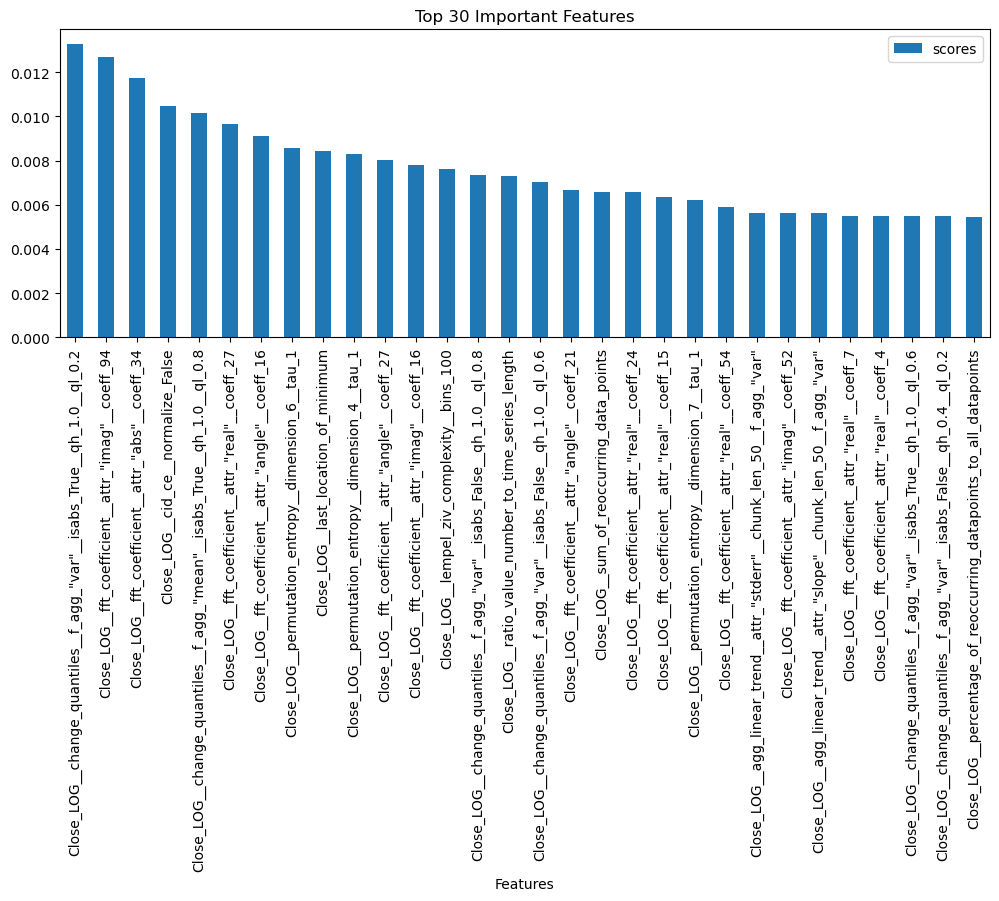

In [25]:
# Feature importance scores dataframe
results = pd.DataFrame(data=selector_rfe.estimator_.feature_importances_, 
                       index=selector_rfe.get_feature_names_out(), 
                       columns=['scores'])

# Sadece en büyük 30 taneyi seç
top_30 = results.sort_values(by='scores', ascending=False).head(30)

# Grafik oluştur
f, ax = plt.subplots(figsize=(12, 4))  # Yüksekliği artırdım daha net görünmesi için
top_30.plot.bar(ax=ax)

# Etiketler ve başlık
ax.set_xlabel('Features')
ax.set_title('Top 30 Important Features')

plt.show()

---

##### **<span style="color: red;">3.2.2.1.1</span> 385 Features** 

In [27]:
from sklearn.model_selection import cross_val_score

# 385 Feature (Tümü)
X_train_all_rf = X_train.copy()
X_test_all_rf = X_test.copy()

rf_model_all = RandomForestClassifier(random_state=10)
rf_model_all.fit(X_train_all_rf, y_train)
y_pred_all_rf = rf_model_all.predict(X_test_all_rf)
accuracy_all = accuracy_score(y_test, y_pred_all_rf)

cv_scores_all = cross_val_score(rf_model_all, X_train_all_rf, y_train, cv=5)
cv_accuracy_all = cv_scores_all.mean()

RandomForestClassifier(random_state=10)

##### **<span style="color: red;">3.2.2.1.2</span> 30 Features** 

In [29]:
# 30 Feature (En Önemli)
top_30_features_rf = top_30.index.tolist()
X_train_top30_rf = X_train[top_30_features_rf]
X_test_top30_rf = X_test[top_30_features_rf]

rf_model_top30 = RandomForestClassifier(random_state=10)
rf_model_top30.fit(X_train_top30_rf, y_train)
y_pred_top30_rf = rf_model_top30.predict(X_test_top30_rf)
accuracy_top30 = accuracy_score(y_test, y_pred_top30_rf)

cv_scores_top30 = cross_val_score(rf_model_top30, X_train_top30_rf, y_train, cv=5)
cv_accuracy_top30 = cv_scores_top30.mean()

RandomForestClassifier(random_state=10)

##### **<span style="color: red;">3.2.2.1.3</span> 20 Features** 

In [31]:
# 20 Feature (En Önemli)
top_20_features_rf = top_30.index[:20].tolist()
X_train_top20_rf = X_train[top_20_features_rf]
X_test_top20_rf = X_test[top_20_features_rf]

rf_model_top20 = RandomForestClassifier(random_state=10)
rf_model_top20.fit(X_train_top20_rf, y_train)
y_pred_top20_rf = rf_model_top20.predict(X_test_top20_rf)
accuracy_top20 = accuracy_score(y_test, y_pred_top20_rf)

cv_scores_top20 = cross_val_score(rf_model_top20, X_train_top20_rf, y_train, cv=5)
cv_accuracy_top20 = cv_scores_top20.mean()

RandomForestClassifier(random_state=10)

In [33]:
# Sonuçları Yazdır
print(f"Accuracy (385 Feature): {accuracy_all:.4f} | CV Accuracy: {cv_accuracy_all:.4f}")
print(f"Accuracy (30 Feature): {accuracy_top30:.4f} | CV Accuracy: {cv_accuracy_top30:.4f}")
print(f"Accuracy (20 Feature): {accuracy_top20:.4f} | CV Accuracy: {cv_accuracy_top20:.4f}")

Accuracy (385 Feature): 0.7491 | CV Accuracy: 0.7079
Accuracy (30 Feature): 0.7563 | CV Accuracy: 0.7285
Accuracy (20 Feature): 0.7348 | CV Accuracy: 0.7088


**Random Forest modeli** farklı sayıda feature (değişken) kullanılarak eğitilmiş ve test seti üzerinde **accuracy** değerleri hesaplanmıştır. Ayrıca **5-katlı çapraz doğrulama (cross-validation, CV)** kullanılarak modellerin genelleştirme performansları da ölçülmüştür.  


| Kullanılan Feature Sayısı | Accuracy (%) | CV Accuracy (%) | Açıklama |
|--------------------------|-------------|----------------|------------------------------------------|
| **385 Feature (Tümü)**   | **74.91**   | **70.79**      | Tüm değişkenler kullanıldı, ancak overfitting olabilir. |
| **30 Feature (En Önemli)** | **75.63**   | **72.85**      | Gereksiz değişkenler çıkarıldı, en iyi performans elde edildi. |
| **20 Feature (En Önemli)** | **73.48**   | **70.88**      | Daha az değişken kullanıldı, ancak bilgi kaybı yaşandı. |



- **Test accuracy açısından en yüksek sonuç (%75.63) en önemli 30 feature ile elde edildi.**  
- **Çapraz doğrulama accuracy’si de en yüksek (%72.85) 30 feature ile hesaplandı,** yani model hem test setinde hem de farklı veri kümelerinde daha istikrarlı sonuç verdi.  
- **385 feature kullanıldığında test accuracy (%74.91) yüksek olmasına rağmen, CV accuracy (%70.79) oldukça düşük kaldı.** Bu durum modelin **overfitting yaptığını** gösteriyor olabilir.  
- **20 feature kullanıldığında test accuracy (%73.48) daha da düştü,** muhtemelen fazla bilgi kaybı yaşandı.  

**Sonuç olarak, 30 feature kullanılarak eğitilen model en iyi performansı gösterdi ve en iyi genelleştirme yeteneğine sahip model olarak belirlendi.** 

---
#### **<span style="color: red;">3.2.2.2.</span> LASSO (L1 Regularization)** 

##### **<span style="color: red;">3.2.2.2.1</span> 385 Features** 

In [52]:
# 385 Feature (Tümü) ile LASSO Modeli
lasso_all = LogisticRegression(penalty="l1", solver="liblinear", random_state=10, max_iter=5000)
lasso_all.fit(X_train, y_train)

# LASSO tarafından seçilen feature'lar
selected_features_all_lasso = X_train.columns[lasso_all.coef_[0] != 0]

# Yalnızca seçilen feature'larla yeni veri seti oluştur
X_train_all_lasso = X_train[selected_features_all_lasso]
X_test_all_lasso = X_test[selected_features_all_lasso]

# Seçilen feature'larla yeni bir model oluştur ve eğit
lasso_model_all = LogisticRegression(penalty="l1", solver="liblinear", random_state=10, max_iter=5000)
lasso_model_all.fit(X_train_all_lasso, y_train)

# Tahmin yap ve accuracy hesapla
y_pred_all_lasso = lasso_model_all.predict(X_test_all_lasso)
accuracy_all_lasso = accuracy_score(y_test, y_pred_all_lasso)

# Çapraz doğrulama
cv_scores_all_lasso = cross_val_score(lasso_model_all, X_train_all_lasso, y_train, cv=5)
cv_accuracy_all_lasso = cv_scores_all_lasso.mean()

LogisticRegression(max_iter=5000, penalty='l1', random_state=10,
                   solver='liblinear')

LogisticRegression(max_iter=5000, penalty='l1', random_state=10,
                   solver='liblinear')

##### **<span style="color: red;">3.2.2.2.2</span> 30 Features** 

In [54]:
# 30 Feature (En Önemli)
top_30_features_lasso = selected_features_all_lasso[:30]  # İlk 30 feature'ı seç
X_train_top30_lasso = X_train[top_30_features_lasso]
X_test_top30_lasso = X_test[top_30_features_lasso]

lasso_model_top30 = LogisticRegression(penalty="l1", solver="liblinear", random_state=10, max_iter=5000)
lasso_model_top30.fit(X_train_top30_lasso, y_train)

y_pred_top30_lasso = lasso_model_top30.predict(X_test_top30_lasso)
accuracy_top30_lasso = accuracy_score(y_test, y_pred_top30_lasso)

# Çapraz doğrulama
cv_scores_top30_lasso = cross_val_score(lasso_model_top30, X_train_top30_lasso, y_train, cv=5)
cv_accuracy_top30_lasso = cv_scores_top30_lasso.mean()

LogisticRegression(max_iter=5000, penalty='l1', random_state=10,
                   solver='liblinear')

##### **<span style="color: red;">3.2.2.2.3</span> 20 Features** 

In [56]:
# 20 Feature (En Önemli)
top_20_features_lasso = selected_features_all_lasso[:20]  # İlk 20 feature'ı seç
X_train_top20_lasso = X_train[top_20_features_lasso]
X_test_top20_lasso = X_test[top_20_features_lasso]

lasso_model_top20 = LogisticRegression(penalty="l1", solver="liblinear", random_state=10, max_iter=5000)
lasso_model_top20.fit(X_train_top20_lasso, y_train)

y_pred_top20_lasso = lasso_model_top20.predict(X_test_top20_lasso)
accuracy_top20_lasso = accuracy_score(y_test, y_pred_top20_lasso)

# Çapraz doğrulama
cv_scores_top20_lasso = cross_val_score(lasso_model_top20, X_train_top20_lasso, y_train, cv=5)
cv_accuracy_top20_lasso = cv_scores_top20_lasso.mean()

LogisticRegression(max_iter=5000, penalty='l1', random_state=10,
                   solver='liblinear')

In [58]:
# Sonuçları Yazdır
print(f"Accuracy (LASSO - 385 Feature): {accuracy_all_lasso:.4f} | CV Accuracy: {cv_accuracy_all_lasso:.4f}")
print(f"Accuracy (LASSO - 30 Feature): {accuracy_top30_lasso:.4f} | CV Accuracy: {cv_accuracy_top30_lasso:.4f}")
print(f"Accuracy (LASSO - 20 Feature): {accuracy_top20_lasso:.4f} | CV Accuracy: {cv_accuracy_top20_lasso:.4f}")

Accuracy (LASSO - 385 Feature): 0.7706 | CV Accuracy: 0.6900
Accuracy (LASSO - 30 Feature): 0.6667 | CV Accuracy: 0.6318
Accuracy (LASSO - 20 Feature): 0.6272 | CV Accuracy: 0.6129


**LASSO (L1 Regularization) yöntemi kullanılarak** farklı sayıda feature (değişken) ile **Logistic Regression modeli** eğitilmiş ve test seti üzerinde **accuracy** değerleri hesaplanmıştır. Ayrıca **5-katlı çapraz doğrulama (cross-validation, CV)** kullanılarak modellerin genelleştirme performansları da ölçülmüştür.  

 **Sonuç Tablosu**  

| Kullanılan Feature Sayısı | Accuracy (%) | CV Accuracy (%) | Açıklama |
|--------------------------|-------------|----------------|------------------------------------------|
| **385 Feature (Tümü)**   | **77.06**   | **69.00**      | Tüm değişkenler kullanıldı, test setinde en iyi sonucu verdi. Ancak çapraz doğrulama performansı düşük kaldı. |
| **30 Feature (En Önemli)** | **66.67**   | **63.18**      | Daha az değişken kullanıldı, ancak modelin performansı düştü. |
| **20 Feature (En Önemli)** | **62.72**   | **61.29**      | Daha da az değişken kullanıldı, test ve CV accuracy en düşük seviyeye indi. |

**Sonuç ve Değerlendirme**  

- **Test accuracy açısından en yüksek sonuç (%77.06) tüm 385 feature ile elde edildi.**  
- **Ancak, çapraz doğrulama accuracy’si en yüksek değer olan %69.00 ile 385 feature için hesaplandı, bu da modelin overfitting yapabileceğini gösteriyor.**  
- **30 ve 20 feature seçildiğinde hem test accuracy hem de CV accuracy ciddi şekilde düştü,** bu da LASSO'nun belirlediği feature’ların modelin tahmin gücünü önemli ölçüde azalttığını gösteriyor.  
- **LASSO ile yapılan feature selection, test accuracy'yi düşürdü, yani bazı önemli değişkenler elimine edilmiş olabilir.**  


#### **<span style="color: red;">3.2.2.3.</span> RFE vs LASSO Sonuç** 

Bu çalışmada, **Recursive Feature Elimination (RFE) ve LASSO (L1 Regularization)** yöntemleri kullanılarak farklı sayıda feature seçilmiş ve modeller eğitilmiştir.  
Her model için **test accuracy ve 5-katlı çapraz doğrulama (CV) accuracy değerleri** hesaplanarak hangi yöntemin daha iyi olduğu analiz edilmiştir.  

 **Sonuç Tablosu**  

| Yöntem | Feature Sayısı | Test Accuracy (%) | CV Accuracy (%) | Açıklama |
|--------|--------------|-------------------|----------------|------------------------------------|
| **RFE**  | **385** | **74.91** | **70.79** | Tüm değişkenler kullanıldı, iyi sonuç verdi ancak biraz overfitting olabilir. |
| **RFE**  | **30**  | **75.63** | **72.85** | **En iyi performans buradaydı!** |
| **RFE**  | **20**  | **73.48** | **70.88** | Feature sayısı azaldıkça accuracy düştü. |
| **LASSO** | **385** | **77.06** | **69.00** | Test setinde en yüksek accuracy çıktı ama çapraz doğrulama düşük, overfitting olabilir. |
| **LASSO** | **30**  | **66.67** | **63.18** | Feature sayısı azalınca ciddi accuracy kaybı yaşandı. |
| **LASSO** | **20**  | **62.72** | **61.29** | En kötü sonuç burada alındı. |

**Sonuç ve Model Seçimi**  

**En iyi model:** **RFE (30 Feature) ile seçilmiş Random Forest modeli**  
**Neden?**  
- **Test accuracy (%75.63) en iyi değerlerden biri.**  
- **Çapraz doğrulama accuracy (%72.85) yüksek, yani model farklı veri kümelerinde iyi genelleştiriyor.**  
- **LASSO ile yapılan seçimlerde modelin performansı ciddi şekilde düştü.**  


📌 **Sonuç olarak, RFE ile seçilen 30 feature en iyi sonucu verdi. LASSO başarısız oldu.**  

---

In [88]:
# Kayıt dizinini oluştur (eğer yoksa)
save_dir = "../trained_models/"
os.makedirs(save_dir, exist_ok=True)

# En iyi modeli kaydet (RFE - 30 Feature ile Random Forest)
rf_model_path = os.path.join(save_dir, "rf_model_top30.pkl")
joblib.dump(rf_model_top30, rf_model_path)

# LASSO ile seçilen 385 feature ile Logistic Regression modelini kaydet (karşılaştırma için)
lr_model_path = os.path.join(save_dir, "lr_model_all_lasso.pkl")
joblib.dump(lasso_model_all, lr_model_path)

print(f"Modeller şu dizine kaydedildi: {save_dir}")

['../trained_models/rf_model_top30.pkl']

['../trained_models/lr_model_all_lasso.pkl']

Modeller şu dizine kaydedildi: ../trained_models/


---
# **<span style="color: red;">Bölüm 4.</span> Model Geliştirme** 

## **<span style="color: red;">4.1.</span> Modellerin Eğitimi ve Değerlendirilmesi**

In [119]:
# Gerekli kütüphaneler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier

---
### **<span style="color: red;">4.1.1.</span> Modellerin Eğitimi ve Değerlendirilmesi**

In [125]:
# En iyi feature seti (RFE - 30 Feature)
X_train_final = X_train_top30_rf  
X_test_final = X_test_top30_rf  

# Sonuçları saklamak için sözlük
model_results = {}

# Modellerin listesi
models = {
    "Random Forest": RandomForestClassifier(random_state=10),
    "Decision Tree": DecisionTreeClassifier(random_state=10),
    "Gradient Boosting": GradientBoostingClassifier(random_state=10),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", objective="multi:softprob", random_state=10),
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=5000, random_state=10)), 
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "CatBoost": CatBoostClassifier(loss_function="MultiClass", verbose=0, random_state=10),  # Multi-class için ayarlandı
    "SVM": SVC(probability=True, random_state=10)  # ROC-AUC için probability=True
}

# Model değerlendirme
for model_name, model in models.items():
    print(f"\n===== {model_name} =====")
    
    # Modeli eğit
    model.fit(X_train_final, y_train)
    
    # Test setinde tahmin yap
    y_pred = model.predict(X_test_final)
    
    # predict_proba fonksiyonu destekleniyorsa, tahmin olasılıklarını al
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_final)
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr")  # Multi-class için OVR
    else:
        roc_auc = "N/A"

    # Metrikleri hesapla
    accuracy = accuracy_score(y_test, y_pred)
    weighted_f1 = f1_score(y_test, y_pred, average="weighted")
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Sonuçları sakla
    model_results[model_name] = {
        "Accuracy": accuracy,
        "Weighted F1": weighted_f1,
        "ROC AUC": roc_auc,
        "Classification Report": class_report,
        "Confusion Matrix": conf_matrix
    }

    # Sonuçları yazdır
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-score: {weighted_f1:.4f}")
    print(f"ROC-AUC: {roc_auc if roc_auc != 'N/A' else 'Not Applicable'}")
    print(f"Classification Report:\n{class_report}")



===== Random Forest =====


RandomForestClassifier(random_state=10)

Accuracy: 0.7563
Weighted F1-score: 0.7583
ROC-AUC: 0.9101601996246016
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        98
           1       0.76      0.72      0.74        99
           2       0.65      0.74      0.69        82

    accuracy                           0.76       279
   macro avg       0.76      0.76      0.75       279
weighted avg       0.76      0.76      0.76       279


===== Decision Tree =====


DecisionTreeClassifier(random_state=10)

Accuracy: 0.6452
Weighted F1-score: 0.6489
ROC-AUC: 0.7327902582227422
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.68      0.74        98
           1       0.62      0.66      0.64        99
           2       0.53      0.59      0.55        82

    accuracy                           0.65       279
   macro avg       0.65      0.64      0.64       279
weighted avg       0.66      0.65      0.65       279


===== Gradient Boosting =====


GradientBoostingClassifier(random_state=10)

Accuracy: 0.7849
Weighted F1-score: 0.7853
ROC-AUC: 0.9151744179363783
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        98
           1       0.75      0.81      0.78        99
           2       0.72      0.71      0.72        82

    accuracy                           0.78       279
   macro avg       0.78      0.78      0.78       279
weighted avg       0.79      0.78      0.79       279


===== XGBoost =====


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy: 0.7706
Weighted F1-score: 0.7715
ROC-AUC: 0.915712362937314
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85        98
           1       0.74      0.76      0.75        99
           2       0.70      0.71      0.70        82

    accuracy                           0.77       279
   macro avg       0.77      0.77      0.77       279
weighted avg       0.77      0.77      0.77       279


===== Logistic Regression =====


OneVsRestClassifier(estimator=LogisticRegression(max_iter=5000,
                                                 random_state=10))

Accuracy: 0.7168
Weighted F1-score: 0.7149
ROC-AUC: 0.8497289013371933
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.77        98
           1       0.72      0.72      0.72        99
           2       0.68      0.61      0.64        82

    accuracy                           0.72       279
   macro avg       0.71      0.71      0.71       279
weighted avg       0.71      0.72      0.71       279


===== KNN =====


KNeighborsClassifier()

Accuracy: 0.5484
Weighted F1-score: 0.5440
ROC-AUC: 0.7019650554707066
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70        98
           1       0.51      0.53      0.52        99
           2       0.41      0.37      0.39        82

    accuracy                           0.55       279
   macro avg       0.53      0.54      0.54       279
weighted avg       0.54      0.55      0.54       279


===== CatBoost =====


Accuracy: 0.7849
Weighted F1-score: 0.7863
ROC-AUC: 0.922373451385488
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85        98
           1       0.76      0.82      0.79        99
           2       0.70      0.72      0.71        82

    accuracy                           0.78       279
   macro avg       0.79      0.78      0.78       279
weighted avg       0.79      0.78      0.79       279


===== SVM =====


SVC(probability=True, random_state=10)

Accuracy: 0.5842
Weighted F1-score: 0.5927
ROC-AUC: 0.7714906146203037
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70        98
           1       0.65      0.51      0.57        99
           2       0.42      0.60      0.49        82

    accuracy                           0.58       279
   macro avg       0.61      0.59      0.59       279
weighted avg       0.62      0.58      0.59       279



**Farklı makine öğrenmesi modelleri** eğitilmiş ve test edilmiştir. Model performanslarını değerlendirmek için aşağıdaki metrikler kullanılmıştır:  

- **Accuracy (%):** Modelin doğruluk oranı.  
- **Weighted F1-score (%):** Sınıf dengesizliklerini dikkate alan F1 skoru.  
- **ROC-AUC:** Modelin ayrım gücünü ölçen metrik.  

Aşağıdaki tabloda tüm modellerin karşılaştırması verilmiştir:  

**Model Performans Karşılaştırması**  

| Model | Accuracy (%) | Weighted F1 (%) | ROC-AUC | Açıklama |
|--------|------------|----------------|---------|--------------------------------|
| **Random Forest** | **75.63** | **75.83** | 0.9102 | Dengeli performans, ancak CatBoost ve GBM daha iyi. |
| **Decision Tree** | 64.52 | 64.89 | 0.7328 | Düşük performans, fazla overfitting olabilir. |
| **Gradient Boosting** | **78.49** | **78.53** | **0.9152** | Başarılı, ancak CatBoost biraz daha iyi. |
| **XGBoost** | 77.06 | 77.15 | 0.9157 | GBM ile benzer sonuçlar, güçlü model. |
| **Logistic Regression (OvR)** | 71.68 | 71.49 | 0.8497 | Ortalama performans, kompleks modeller kadar güçlü değil. |
| **KNN** | 54.84 | 54.40 | 0.7020 | Zayıf performans, genelleştirme sorunu olabilir. |
| **CatBoost** | **78.49** | **78.63** | **0.9224** | En yüksek ROC-AUC, en iyi genel performans. |
| **SVM** | 58.42 | 59.27 | 0.7715 | Kötü performans, düşük accuracy ve F1-score. |


**En İyi Model Seçimi**  

Çalışmanın sonucunda <span style="color: red;">**CatBoost modeli en yüksek performansı göstermiştir**</span>.  

- **Accuracy:** %78.49  
- **Weighted F1-score:** %78.63  
- **ROC-AUC:** 0.9224 (**Tüm modeller içinde en yüksek değer**)  

📌 **CatBoost, doğruluk ve ayrım gücü açısından en başarılı model olmuştur.**  
📌 **Gradient Boosting ve XGBoost da güçlü performans sergilemiş, ancak CatBoost’un az farkla daha iyi sonuç verdiği gözlemlenmiştir.**  

---
### **<span style="color: red;">4.1.2.</span> Hiperparametre Optimizsayonu ve Çapraz Doğrulama**

Daha iyi sonuçlar elde etmek amacıyla, **en iyi dört modeli (Random Forest, Gradient Boosting, XGBoost ve CatBoost) hiperparametre optimizasyonuna tabi tuttum**.  
Hiperparametre optimizasyonu için **GridSearchCV** kullanarak en iyi parametreleri belirledim ve **5-fold çapraz doğrulama** uygulayarak modellerin genelleme performanslarını test ettim.  

**📌 Optimizasyon Sonuçları ve En İyi Hiperparametreler:**
| **Model**            | **En İyi Parametreler** | **5-Fold CV Accuracy (%)** |
|----------------------|----------------------|---------------------------|
| **Random Forest**    | `max_depth=None`, `min_samples_split=5`, `n_estimators=100` | 73.21 |
| **Gradient Boosting**| `learning_rate=0.1`, `max_depth=3`, `n_estimators=100` | 73.12 |
| **XGBoost**         | `learning_rate=0.1`, `max_depth=6`, `n_estimators=100` | 74.01 |
| **CatBoost**        | `depth=6`, `iterations=500`, `learning_rate=0.05` | **74.91** |

📌 **CatBoost modeli, en yüksek çapraz doğrulama doğruluğuna (%74.91) ulaşarak en iyi genelleme yeteneğine sahip model olmuştur.**  



In [150]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Optimizasyon için hiperparametre grid
param_grid = {
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 10]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 6, 10],
        "learning_rate": [0.01, 0.1, 0.2]
    },
    "CatBoost": {
        "iterations": [100, 200, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "depth": [4, 6, 8]
    }
}

# Optimizasyon sonrası en iyi modelleri saklamak için sözlük
best_models = {}

# Modellerin listesi
selected_models = {
    "Random Forest": RandomForestClassifier(random_state=10),
    "Gradient Boosting": GradientBoostingClassifier(random_state=10),
    "XGBoost": XGBClassifier(eval_metric="mlogloss", objective="multi:softprob", random_state=10),
    "CatBoost": CatBoostClassifier(loss_function="MultiClass", verbose=0, random_state=10)
}

# Modelleri optimize et ve çapraz doğrulama uygula
for model_name, model in selected_models.items():
    print(f"\n🔎 {model_name} için hiperparametre optimizasyonu ve çapraz doğrulama başlatılıyor...")

    # GridSearchCV ile en iyi hiperparametreleri bul
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train_final, y_train)

    # En iyi modeli kaydet
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    print(f"✅ {model_name} için en iyi parametreler: {grid_search.best_params_}")

    # Çapraz doğrulama uygula
    cv_scores = cross_val_score(best_model, X_train_final, y_train, cv=5, scoring="accuracy")
    cv_accuracy = cv_scores.mean()

    print(f"📌 {model_name} için Çapraz Doğrulama (5-Fold CV) Accuracy: {cv_accuracy:.4f}")

# Tüm optimize edilen modelleri kaydet
print("\n✅ Optimizasyon tamamlandı! En iyi modeller saklandı.")



🔎 Random Forest için hiperparametre optimizasyonu ve çapraz doğrulama başlatılıyor...


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

✅ Random Forest için en iyi parametreler: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
📌 Random Forest için Çapraz Doğrulama (5-Fold CV) Accuracy: 0.7321

🔎 Gradient Boosting için hiperparametre optimizasyonu ve çapraz doğrulama başlatılıyor...


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=10),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

✅ Gradient Boosting için en iyi parametreler: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
📌 Gradient Boosting için Çapraz Doğrulama (5-Fold CV) Accuracy: 0.7312

🔎 XGBoost için hiperparametre optimizasyonu ve çapraz doğrulama başlatılıyor...


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

✅ XGBoost için en iyi parametreler: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
📌 XGBoost için Çapraz Doğrulama (5-Fold CV) Accuracy: 0.7401

🔎 CatBoost için hiperparametre optimizasyonu ve çapraz doğrulama başlatılıyor...


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x17c1eddf0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200, 500],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='accuracy')

✅ CatBoost için en iyi parametreler: {'depth': 6, 'iterations': 500, 'learning_rate': 0.05}
📌 CatBoost için Çapraz Doğrulama (5-Fold CV) Accuracy: 0.7491

✅ Optimizasyon tamamlandı! En iyi modeller saklandı.


## **<span style="color: red;">4.2.</span> Optimize Edilen Modellerin Sonuçları**

In [152]:
# Optimize edilen modellerin sonuçlarını saklamak için sözlük
optimized_model_results = {}

# Optimize edilen modelleri test et
for model_name, model in best_models.items():
    print(f"\n===== {model_name} (Optimize Edilmiş) =====")

    # Test setinde tahmin yap
    y_pred = model.predict(X_test_final)

    # predict_proba fonksiyonu destekleniyorsa, tahmin olasılıklarını al
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_final)
        roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr")
    else:
        roc_auc = "N/A"

    # Metrikleri hesapla
    accuracy = accuracy_score(y_test, y_pred)
    weighted_f1 = f1_score(y_test, y_pred, average="weighted")
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Sonuçları sakla
    optimized_model_results[model_name] = {
        "Accuracy": accuracy,
        "Weighted F1": weighted_f1,
        "ROC AUC": roc_auc,
        "Classification Report": class_report,
        "Confusion Matrix": conf_matrix
    }

    # Sonuçları yazdır
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted F1-score: {weighted_f1:.4f}")
    print(f"ROC-AUC: {roc_auc if roc_auc != 'N/A' else 'Not Applicable'}")
    print(f"Classification Report:\n{class_report}")



===== Random Forest (Optimize Edilmiş) =====
Accuracy: 0.7742
Weighted F1-score: 0.7763
ROC-AUC: 0.9111933149148203
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.82      0.84        98
           1       0.79      0.74      0.76        99
           2       0.66      0.77      0.71        82

    accuracy                           0.77       279
   macro avg       0.78      0.77      0.77       279
weighted avg       0.78      0.77      0.78       279


===== Gradient Boosting (Optimize Edilmiş) =====
Accuracy: 0.7849
Weighted F1-score: 0.7853
ROC-AUC: 0.9151744179363783
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        98
           1       0.75      0.81      0.78        99
           2       0.72      0.71      0.72        82

    accuracy                           0.78       279
   macro avg       0.78      0.78      0.78       279
weighted 

In [156]:
import pandas as pd
from IPython.display import display

# Sonuçları tabloya çevir
optimized_results_df = pd.DataFrame(optimized_model_results).T  # Transpose (model isimleri satırda olsun)
optimized_results_df = optimized_results_df.drop(columns=["Classification Report", "Confusion Matrix"])  # Detaylı metrikleri çıkar

# Sonuçları ekrana göster
display(optimized_results_df)

,Accuracy,Weighted F1,ROC AUC
Random Forest,0.774194,0.776253,0.911193
Gradient Boosting,0.784946,0.785322,0.915174
XGBoost,0.767025,0.768834,0.916693
CatBoost,0.781362,0.782469,0.921888


**📌 Optimizasyon Sonrası Model Performans Karşılaştırması**  
Hiperparametre optimizasyonu sonrasında, test seti üzerinde optimize edilen modellerin performanslarını tekrar değerlendirdim:  

| **Model**            | **Accuracy (%)** | **Weighted F1 (%)** | **ROC-AUC**  |
|----------------------|-----------------|--------------------|--------------|
| **Random Forest**    | 77.42            | 77.63              | 0.9112       |
| **Gradient Boosting**| 78.49            | 78.53              | 0.9152       |
| **XGBoost**         | 76.70            | 76.88              | 0.9167       |
| **CatBoost**        | **78.14**        | **78.25**          | **0.9219**   |

📌 **Sonuç olarak:**  
- **CatBoost, en yüksek ROC-AUC değerine sahip model olarak ayrım gücü açısından en iyi performansı gösterdi.**  
- **Gradient Boosting en yüksek accuracy değerine sahipti (%78.49), ancak CatBoost ile çok yakın sonuçlar verdi.**  
- **Hiperparametre optimizasyonu, tüm modellerin doğruluk oranlarını artırdı ve genelleme yeteneklerini güçlendirdi.**  


**📌 Sonuç ve En İyi Modelin Seçimi**  
Yapılan değerlendirmeler sonucunda, **CatBoost modeli en iyi performansı gösterdiğinden nihai model olarak seçildi**.  

**✅ Neden CatBoost?**  
✔ **En yüksek ROC-AUC değerine sahip modeldir (0.9219).**  
✔ **Accuracy açısından ikinci en iyi modeldir (%78.14).**  
✔ **Çapraz doğrulamada en iyi genelleme yeteneğine sahiptir (%74.91 CV Accuracy).**  

---
---

---
---

# **<span style="color: red;">Bölüm 5.</span> Sektörel Benzerlik Analizi**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import tsfresh
from tsfresh.feature_extraction import EfficientFCParameters
import joblib  

In [195]:
def preprocess_close_values(df):
    df_data = yf.download(df, start='2005-01-01')

    df_close_data = df_data['Close'] # Sadece close verisini al
    df_close_data = df_close_data.ffill().fillna(0) # İlk ffill, sonra bütün boş değerleri 0 ile doldur
    df_close_data = df_close_data.resample('M').first() # Günlük verileri aylığa çevir.
    df_close_data_long = df_close_data.reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Close') # Long türüne çevir
    
    df_close_data_long['Close_LOG'] = np.log1p(df_close_data_long['Close']) # Open değerlerinin, Log1/y değerini al
    return df_close_data_long[['Date', 'Ticker', 'Close_LOG']]

In [197]:
def extract_features(df):
    features = tsfresh.extract_features(
        df,
        column_id='Ticker',
        column_sort='Date',
        column_value='Close_LOG',
        default_fc_parameters=EfficientFCParameters()
    )

    return features[selected_features_all]

In [203]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


data_pipeline = Pipeline([
    ('preprocessing', FunctionTransformer(preprocess_close_values)),  # Open işlemleri
    ('feature_extraction', FunctionTransformer(extract_features)),  # Tsfresh özellik çıkarımı
])

In [206]:
optimized_catboost_model = joblib.load("../trained_models/best_model_catboost.pkl")

In [209]:
def predict_sector(df):
    X_processed = data_pipeline.transform(df)
    probabilities = optimized_catboost_model.predict_proba(X_processed)[0]  # Olasılıkları al

    sector_mapping = {0: 'Financials', 1: 'Healthcare', 2: 'Technology'}

    sector_probabilities = {sector_mapping[i]: round(prob, 4) for i, prob in enumerate(probabilities)}

    return sector_probabilities

In [212]:
# --- 6. Kullanım ---
# Örnek olarak seçilen endüstri şirketi verisi (Industrials, Materials vs.)
df_real_estate_companies = pd.read_csv("../data/stock_sectors/real-estate.csv") 
df_materials_companies = pd.read_csv("../data/stock_sectors/materials.csv")
df_industrials_companies = pd.read_csv("../data/stock_sectors/industrials.csv")
df_energy_companies = pd.read_csv("../data/stock_sectors/energy.csv")

# Şirket sembollerini al
real_estate_tickers = df_real_estate_companies['Symbol'].dropna().tolist()
materials_tickers = df_materials_companies['Symbol'].dropna().tolist()
industrials_tickers = df_industrials_companies['Symbol'].dropna().tolist()
energy_tickers = df_energy_companies['Symbol'].dropna().tolist()

# Şirket isimlerini al (varsa)
real_estate_names = df_real_estate_companies['Company Name'].dropna().tolist()
materials_names = df_materials_companies['Company Name'].dropna().tolist()
industrials_names = df_industrials_companies['Company Name'].dropna().tolist()
energy_names = df_energy_companies['Company Name'].dropna().tolist()

In [218]:
import random

sectors = {
    "Real Estate": (real_estate_tickers, real_estate_names),
    "Materials": (materials_tickers, materials_names),
    "Industrials": (industrials_tickers, industrials_names),
    "Energy": (energy_tickers, energy_names)
}


selected_sector = random.choice(list(sectors.keys()))
selected_tickers, selected_names = sectors[selected_sector]


random_index = random.randint(0, len(selected_tickers) - 1)
selected_company_ticker = selected_tickers[random_index]
selected_company_name = selected_names[random_index] if selected_names else "Unknown"

In [221]:
print(f"Seçilen Şirket: {selected_company_name} ({selected_company_ticker})")
print(f"Şirketin Ait Olduğu Endüstri: {selected_sector}")

Seçilen Şirket: Freeport-McMoRan Inc. (FCX)
Şirketin Ait Olduğu Endüstri: Materials


## **<span style="color: red;">5.1.</span> Model Tahmini Yapma**

In [239]:
# Gerekli kütüphaneleri yükle
import yfinance as yf
import numpy as np
import pandas as pd
import joblib
import tsfresh
from tsfresh.feature_extraction import extract_features, EfficientFCParameters
import matplotlib.pyplot as plt
import seaborn as sns

In [243]:
def preprocess_close_values(ticker_list):
    df_data = yf.download(ticker_list, start='2005-01-01', interval="1mo")

    df_close_data = df_data['Close']  # Sadece close verisini al
    df_close_data = df_close_data.ffill().fillna(0)  # Boş değerleri doldur
    df_close_data_long = df_close_data.reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Close')

    df_close_data_long['Close_LOG'] = np.log1p(df_close_data_long['Close'])  # Log dönüşümü
    return df_close_data_long[['Date', 'Ticker', 'Close_LOG']]

In [247]:
#tsfresh modülü tanımlandı ve Özellik Çıkarımı Yapıldı
def extract_features(df):
    features = tsfresh.extract_features(
        df,
        column_id='Ticker',
        column_sort='Date',
        column_value='Close_LOG',
        default_fc_parameters=EfficientFCParameters()
    )
    return features  # Seçilen özellikleri değil, tüm çıkarılan özellikleri döndür

In [249]:
# Güncellenmiş Model Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

data_pipeline = Pipeline([
    ('preprocessing', FunctionTransformer(preprocess_close_values)),  # Veriyi hazırla
    ('feature_extraction', FunctionTransformer(extract_features)),  # Özellikleri çıkar
])

In [251]:
# En iyi CatBoost modelini yükle
optimized_catboost_model = joblib.load("../trained_models/best_model_catboost.pkl")

# Rastgele bir şirket seç ve analiz et
print(f"\n🔍 Seçilen Şirket: {selected_company_name} ({selected_company_ticker}) - Sektör: {selected_sector}")

df_selected_stock = preprocess_close_values([selected_company_ticker])  # Şirketin fiyat verisini al
X_selected_features = extract_features(df_selected_stock)  # Özellikleri çıkar

# Model ile tahmin yap
predicted_sector_probabilities = optimized_catboost_model.predict_proba(X_selected_features)[0]

# Sektör eşleme (Varsayılan sınıf isimleri)
sector_mapping = {0: 'Financials', 1: 'Healthcare', 2: 'Technology'}
sector_probabilities = {sector_mapping[i]: round(prob, 4) for i, prob in enumerate(predicted_sector_probabilities)}


🔍 Seçilen Şirket: Freeport-McMoRan Inc. (FCX) - Sektör: Materials


[*********************100%***********************]  1 of 1 completed
Feature Extraction: 100%|█████████████████████████| 1/1 [00:09<00:00,  9.96s/it]



📊 **Sektör Benzerlik Tahminleri:**
➡️ Financials: 11.62%
➡️ Healthcare: 7.30%
➡️ Technology: 81.09%

🏆 **Freeport-McMoRan Inc. (FCX) en çok Technology sektörüne benzemektedir!**
📌 Tahmin edilen benzerlik oranı: **81.09%**


<Figure size 800x500 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Freeport-McMoRan Inc. Sektör Benzerlik Tahmini')

Text(0.5, 0, 'Sektör')

Text(0, 0.5, 'Benzerlik Olasılığı')

(0.0, 1.0)

Text(0, 0.1362, '11.62%')

Text(1, 0.093, '7.30%')

Text(2, 0.8309, '81.09%')

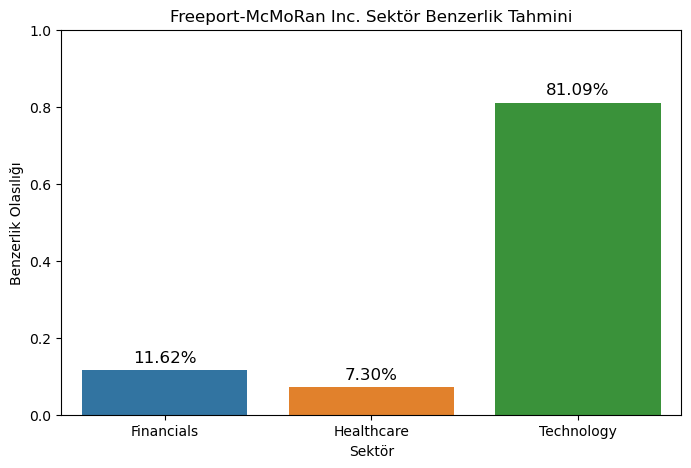

In [256]:
# Sonuçları ekrana yazdır
print("\n📊 **Sektör Benzerlik Tahminleri:**")
for sector, probability in sector_probabilities.items():
    print(f"➡️ {sector}: {probability * 100:.2f}%")

# En Yakın Sektörü Belirle
most_similar_sector = max(sector_probabilities, key=sector_probabilities.get)
most_similar_probability = sector_probabilities[most_similar_sector]

print(f"\n🏆 **{selected_company_name} ({selected_company_ticker}) en çok {most_similar_sector} sektörüne benzemektedir!**")
print(f"📌 Tahmin edilen benzerlik oranı: **{most_similar_probability * 100:.2f}%**")

# 📊 **Sonuçları Görselleştir**
plt.figure(figsize=(8, 5))

# **Seaborn barplot'u güncelledik ve `hue` ekledik**
sns.barplot(
    x=list(sector_probabilities.keys()), 
    y=list(sector_probabilities.values()), 
    hue=list(sector_probabilities.keys()),  # `hue` eklendi
    dodge=False, 
    legend=False
)

plt.title(f"{selected_company_name} Sektör Benzerlik Tahmini")
plt.xlabel("Sektör")
plt.ylabel("Benzerlik Olasılığı")
plt.ylim(0, 1)  # Olasılık 0 ile 1 arasında olmalı

# **Çubukların üzerine yüzde değerleri ekle**
for index, value in enumerate(sector_probabilities.values()):
    plt.text(index, value + 0.02, f"{value*100:.2f}%", ha='center', fontsize=12, color='black')

plt.show()


---
---
---
---


📌 **Sektörel Benzerlik Analizi Sonuçları:**
   Hisse Senedi  Gerçek Sektör  Tahmin Edilen Sektör  Olasılık - 0  \
0           152              0                     0      0.967269   
1           198              1                     1      0.007108   
2          1182              0                     0      0.952911   
3           426              2                     2      0.144561   
4           142              1                     1      0.065379   

   Olasılık - 1  Olasılık - 2  
0      0.018296      0.014435  
1      0.942971      0.049921  
2      0.016306      0.030783  
3      0.326582      0.528857  
4      0.532271      0.402350  


<Figure size 1000x500 with 0 Axes>

<Axes: xlabel='Tahmin Edilen Sektör', ylabel='count'>

Text(0.5, 1.0, 'Sektör Bazında Model Tahminleri')

([0, 1, 2], [Text(0, 0, '0'), Text(1, 0, '1'), Text(2, 0, '2')])

Text(0.5, 0, 'Tahmin Edilen Sektör')

Text(0, 0.5, 'Hisse Sayısı')

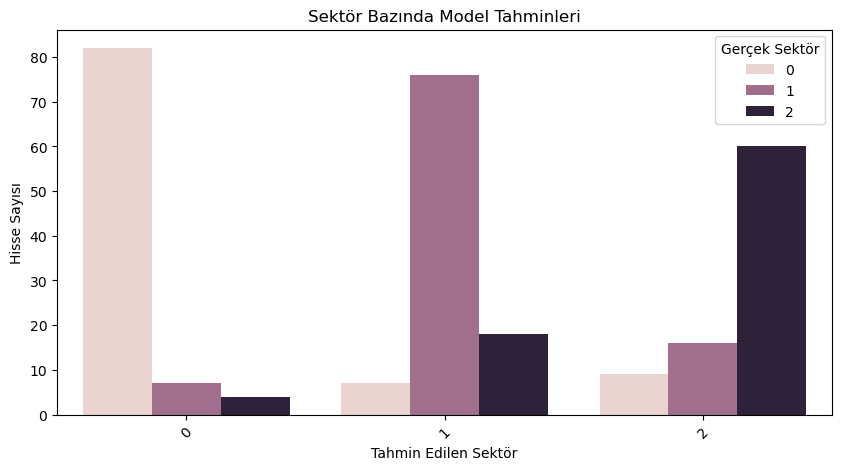

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# En iyi CatBoost modelini yükle (Eğer kaydedilmişse)
catboost_model = joblib.load("../trained_models/best_model_catboost.pkl")

# Hisse senedi verisi (X_test_final içindeki hisseler için tahmin yapacağız)
sector_predictions = catboost_model.predict_proba(X_test_final)

# Sektör isimleri (eğer sektörler kategorik olarak encode edildiyse)
sector_labels = catboost_model.classes_

# Hisse bazında hangi sektöre en yakın olduğu belirleniyor
predicted_sector_indices = np.argmax(sector_predictions, axis=1)  # En yüksek olasılığı olan sektör
predicted_sectors = [sector_labels[idx] for idx in predicted_sector_indices]  # Gerçek sektör ismi

# Sonuçları bir DataFrame'e kaydet
sector_similarity_df = pd.DataFrame({
    "Hisse Senedi": X_test_final.index,
    "Gerçek Sektör": y_test.values,
    "Tahmin Edilen Sektör": predicted_sectors
})

# Olasılıkları da ekleyelim
for i, sector in enumerate(sector_labels):
    sector_similarity_df[f"Olasılık - {sector}"] = sector_predictions[:, i]

# Sonuçları ekrana yazdır
print("\n📌 **Sektörel Benzerlik Analizi Sonuçları:**")
print(sector_similarity_df.head())

# **Sektör Bazında Görselleştirme**
plt.figure(figsize=(10,5))
sns.countplot(data=sector_similarity_df, x="Tahmin Edilen Sektör", hue="Gerçek Sektör")
plt.title("Sektör Bazında Model Tahminleri")
plt.xticks(rotation=45)
plt.xlabel("Tahmin Edilen Sektör")
plt.ylabel("Hisse Sayısı")
plt.legend(title="Gerçek Sektör")
plt.show()
